# Тестовое задание: основные метрики для e-mail рассылок

## Задача

На основе тестового набора данных необходимо посчитать следующие метрики:
- Delivery rate,
- Open rate,
- Click to Open rate,
- Unsubscribe rate.

Также нужно:
- выявить лучшую тему,
- выявить лучший день недели (для планирования рассылок).

## Загрузка данных

In [81]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

pd.set_option('display.float_format', '{:.2f}'.format) # два знака после точки для float

In [4]:
df = pd.read_excel('https://docs.google.com/spreadsheets/d/' + 
                   '1kd_g0P04hmV7jtyxR886AYQxxIoPPXbRIPV3hwCqhPs' +
                   '/export?gid=0&format=xlsx',
                     sheet_name='Data',parse_dates=['Дата'])
df.head()

,Название рассылки,Название кампании,Направление,Месяц,Дата,Год,Номер недели,День недели,День недели.1,Время,...,Доставлено,Открытия,Клики,Баунсы (Все ошибки),Отписки,UTM Метка,Пользователей на сайте,Воронка продаж. Шаг 1,Воронка продаж. Шаг 2,Воронка продаж. Шаг 3
0,Название рассылки 1,Название кампании 1,Email,Октябрь,2021-10-27,2021,43,3,03-среда,19:24:00,...,741749.55,148349.910,17801.98920,39039.45,7417.4955,Метка 1,16377.830064,6336.582452,6209.850803,5154.176166
1,Название рассылки 10,Название кампании 10,Email,Ноябрь,2021-11-05,2021,45,5,05-пятница,12:02:00,...,683401.50,123012.270,11071.10430,35968.50,6834.0150,Метка 10,10296.126999,3558.341491,3095.757097,2538.520820
2,Название рассылки 100,Название кампании 100,Email,Апрель,2022-04-11,2022,15,1,01-понедельник,16:26:00,...,1141344.25,182615.080,15339.66672,60070.75,11413.4425,Метка 100,13959.096715,3369.725947,2864.267055,2262.770973
3,Название рассылки 101,Название кампании 101,Email,Апрель,2022-04-12,2022,15,2,02-вторник,16:26:00,...,1324135.65,264827.130,10328.25807,69691.35,13241.3565,Метка 101,8985.584521,5116.391826,4277.303567,3207.977675
4,Название рассылки 102,Название кампании 102,Email,Апрель,2022-04-13,2022,15,3,03-среда,16:26:00,...,1212979.95,218336.391,15720.22015,63841.05,12129.7995,Метка 102,10846.951905,2816.953410,2287.366169,1669.777303


## Предварительная обработка

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Название рассылки       218 non-null    object        
 1   Название кампании       218 non-null    object        
 2   Направление             218 non-null    object        
 3   Месяц                   218 non-null    object        
 4   Дата                    218 non-null    datetime64[ns]
 5   Год                     218 non-null    int64         
 6   Номер недели            218 non-null    int64         
 7   День недели             218 non-null    int64         
 8   День недели.1           218 non-null    object        
 9   Время                   218 non-null    object        
 10  Веб-версия              218 non-null    object        
 11  Тема письма             218 non-null    object        
 12  Сегмент                 218 non-null    object    

Пропусков в данных нет, типы данных корректные (разве что можно `Время` перевести в `datetime`, но для этой задачи в этом нет необходимости).

Проверим, есть ли дубликаты.

In [8]:
df.duplicated(subset=['Название рассылки']).sum()

0

In [9]:
df.duplicated(subset=['UTM Метка']).sum()

0

Явных дубликатов тоже нет.

Избавимся от лишних пробелов в конце названий столбцов.

In [57]:
df.columns = [x.strip() for x in df.columns]
df.columns

Index(['Название рассылки', 'Название кампании', 'Направление', 'Месяц',
       'Дата', 'Год', 'Номер недели', 'День недели', 'День недели.1', 'Время',
       'Веб-версия', 'Тема письма', 'Сегмент', 'Отправлено', 'Доставлено',
       'Открытия', 'Клики', 'Баунсы (Все ошибки)', 'Отписки', 'UTM Метка',
       'Пользователей на сайте', 'Воронка продаж. Шаг 1',
       'Воронка продаж. Шаг 2', 'Воронка продаж. Шаг 3', 'Delivery rate',
       'Open rate', 'CTOR', 'Unsubscribe rate'],
      dtype='object')

## Исследовательский анализ данных

### Метрики

In [11]:
df['Delivery rate'] = df['Доставлено']/df['Отправлено'] * 100
df['Open rate'] = df['Открытия']/df['Доставлено'] * 100
df['CTOR'] = df['Клики']/df['Открытия'] * 100
df['Unsubscribe rate'] = df['Отписки']/df['Отправлено'] * 100

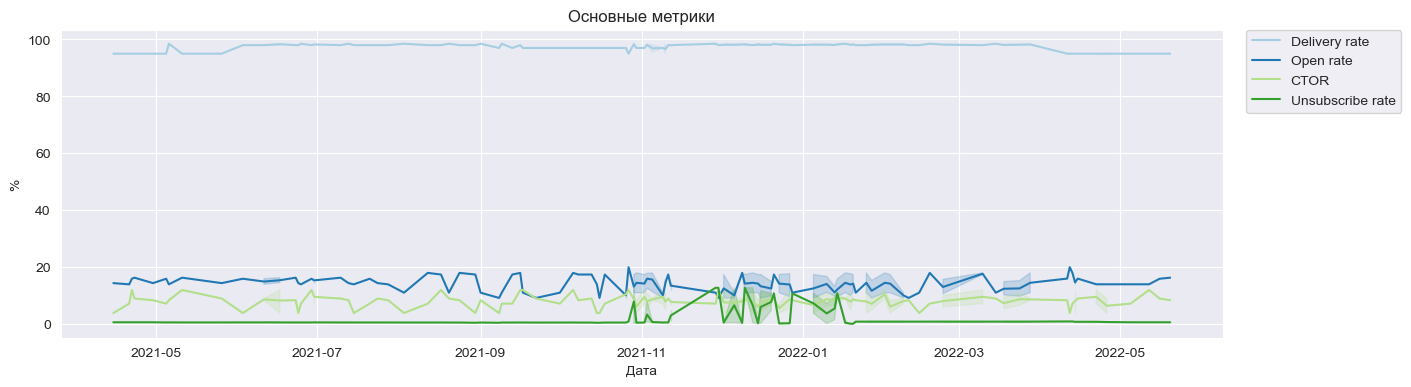

In [76]:
dfm = df[['Дата', 'Delivery rate','Open rate','CTOR','Unsubscribe rate']].melt(id_vars='Дата', var_name='Metric_name', value_name='Metric')

# Зададим цветовую схему графика
sns.set_style('darkgrid')

# Покажем динамику метрик на графике
fig, ax = plt.subplots(figsize=(15, 4))
sns.lineplot(data=dfm, x='Дата', y='Metric', hue='Metric_name')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Дата')
plt.ylabel('%')
plt.title('Основные метрики');

### Лучшая тема

Для начала определимся, что значит "лучшая" тема. Когда получатель решает, открыть письмо или нет, он видит только его тему. Значит, по значению метрики `Open rate` мы можем судить о привлекательности темы.

Найдём тему письма с самым высоким значением `Open rate`.

In [63]:
df[['Тема письма','Open rate']].loc[df['Open rate']==df['Open rate'].max()]

,Тема письма,Open rate
0,Тема письма 1,20.0
3,Тема письма 101,20.0


**Вывод:** Лучшие темы - "Тема письма1" и "Тема письма 101".

### Лучший день недели

Лучший день недели - это день, когда получатели больше склонны открывать письма и переходить по ссылкам. Посмотрим, есть ли различия в `Open rate` и `CTOR` по дням недели.

In [77]:
df.groupby(by='День недели')[['Open rate','CTOR']].mean()

,Open rate,CTOR
День недели,,
1,13.59,8.14
2,13.49,8.98
3,14.33,8.01
4,13.70,7.91
5,13.66,8.13
6,13.80,6.84


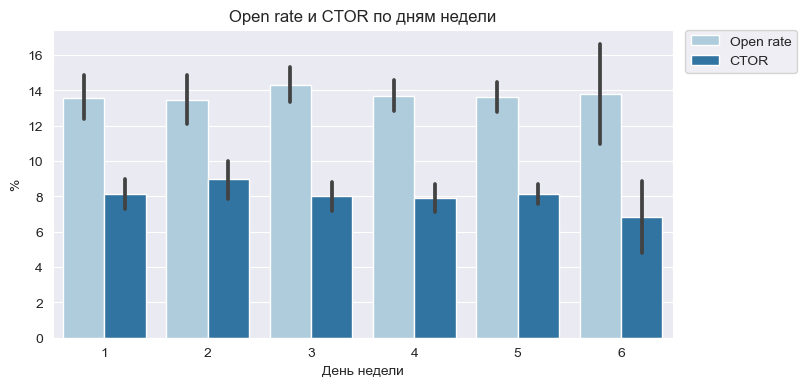

In [73]:
dfm0 = df[['День недели', 'Open rate','CTOR']].melt(id_vars='День недели', var_name='Metric_name', value_name='Metric')
fig, ax = plt.subplots(figsize=(8, 4))
ax = sns.barplot(x='День недели', 
                 y='Metric', 
                 data=dfm0, 
                 hue='Metric_name')
plt.xlabel('День недели')
plt.ylabel('%')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title('Open rate и CTOR по дням недели');

Больше писем открывают **в среду**, но по ссылкам переходят больше **во вторник**. Поскольку переход по ссылке - более значимое действие для бизнеса, то и день с более высоким CTOR будет приоритетнее. Однако нужно проверить, является ли значимой разница между средним CTOR во вторник и средним CTOR в другие дни. Сделаем такую же проверку и для Open rate в среду и в другие дни.

### Проверка гипотез

#### Гипотеза 1: Средний CTOR по вторникам не отличается от среднего CTOR в другие дни недели

Посчитаем средние CTOR для вторников и для всех остальных дней недели:

In [79]:
df.loc[df['День недели']==2, 'CTOR'].mean()

8.976000000337098

In [80]:
df.loc[df['День недели']!=2, 'CTOR'].mean()

8.012953367582314

Сформулируем нулевую и альтернативную гипотезы и зададим пороговое значение *alpha*:
```
H_0: Средний CTOR по вторникам = Средний CTOR в другие дни`
H_a: Средний CTOR по вторникам ≠ Средний CTOR в другие дни`
alpha = 0.05
```

*Нулевая гипотеза* выражает предположение, что различия между средними значениями двух совокупностей имеют случайный характер. *Альтернативная гипотеза* предполагает, что между средними значениями двух совокупностей есть достоверные различия.

Для проверки правдоподобия гипотез используем t-критерий Стьюдента, а именно двухвыборочный t-критерий для независимых выборок, так как реакция получателей на одни рассылки не связана с реакцией получателей на другие рассылки.

In [84]:
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(df.loc[df['День недели']==2, 'CTOR'], 
                       df.loc[df['День недели']!=2, 'CTOR'],
                      equal_var=False)

# alpha = зададим значение уровня значимости
alpha = .05

# вывод значения p-value на экран 
print('p-value:', results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
# если p-value окажется меньше него, отвергнем гипотезу
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-value: 0.11971824451880463
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза не отвергается, значит нельзя сделать вывод, что средние значения CTOR во вторник и в другие дни отличаются.

#### Гипотеза 2: Средний Open rate по средам не отличается от среднего Open rate в другие дни недели
Посчитаем средние Open rate для сред и для остальных дней недели.

In [85]:
df.loc[df['День недели']==3, 'Open rate'].mean()

14.326750000554217

In [86]:
df.loc[df['День недели']!=3, 'Open rate'].mean()

13.637247191276646

Сформулируем нулевую и альтернативную гипотезы и зададим пороговое значение *alpha*:
```
H_0: Средний Open rate по средам = Средний Open rate в другие дни`
H_a: Средний Open rate по средам ≠ Средний Open rate в другие дни`
alpha = 0.05
```

In [87]:
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(df.loc[df['День недели']==3, 'Open rate'], 
                       df.loc[df['День недели']!=3, 'Open rate'],
                      equal_var=False)

# alpha = зададим значение уровня значимости
alpha = .05

# вывод значения p-value на экран 
print('p-value:', results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
# если p-value окажется меньше него, отвергнем гипотезу
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-value: 0.24560671580060248
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза не отвергается, значит нельзя сделать вывод, что средние значения Open rate в среду и в другие дни отличаются.

## Вывод